## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/yiheng/.local/lib/python3.7/site-packages/tensorflow/py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[1000, 500, 200, 100, 50]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )

earlystop1 = EarlyStopping(monitor="Val_Accuracy", 
                          patience=10, 
                          verbose=1
                          )

earlystop2 = EarlyStopping(monitor="Val_Accuracy", 
                          patience=25, 
                          verbose=1
                          )


In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
#origenal
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "earlystop-5"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1000)              3073000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 500)               500500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 200)               100200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800 

W0108 02:05:37.112085 4567989696 deprecation_wrapper.py:119] From /Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.2502 - accuracy: 0.2543 - val_loss: 2.1787 - val_accuracy: 0.2326
Epoch 2/50
50000/50000 [==============================] - 6s 120us/step - loss: 1.7800 - accuracy: 0.3806 - val_loss: 2.0083 - val_accuracy: 0.3056
Epoch 3/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.6386 - accuracy: 0.4284 - val_loss: 1.8572 - val_accuracy: 0.3711
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.5435 - accuracy: 0.4609 - val_loss: 1.7505 - val_accuracy: 0.4001
Epoch 5/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.4710 - accuracy: 0.4872 - val_loss: 1.6700 - val_accuracy: 0.4240
Epoch 6/50
50000/50000 [==============================] - 5s 106us/step - loss: 1.4066 - accuracy: 0.5110 - val_loss: 1.6131 - val_accuracy: 0.4386
Epoch 7/50
50000/50000 [==============================] - 6s 1

In [9]:
#earlystop10
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop1]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "earlystop-10"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1000)              3073000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 500)               500500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 200)               100200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800 

/Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `Val_Accuracy` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 6s 129us/step - loss: 1.7689 - accuracy: 0.3800 - val_loss: 1.9992 - val_accuracy: 0.3009
Epoch 3/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.6241 - accuracy: 0.4313 - val_loss: 1.8646 - val_accuracy: 0.3565
Epoch 4/50
50000/50000 [==============================] - 6s 118us/step - loss: 1.5330 - accuracy: 0.4653 - val_loss: 1.7653 - val_accuracy: 0.3822
Epoch 5/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.4648 - accuracy: 0.4883 - val_loss: 1.6874 - val_accuracy: 0.4132
Epoch 6/50
50000/50000 [==============================] - 9s 178us/step - loss: 1.4044 - accuracy: 0.5129 - val_loss: 1.6133 - val_accuracy: 0.4324
Epoch 7/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.3499 - accuracy: 0.5345 - val_loss: 1.5727 - val_accuracy: 0.4496
Epoch 8/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.2990 - accuracy: 0.5526 - val_loss: 1.561

In [10]:
#earlystop25
keras.backend.clear_session() # 把舊的 Graph 清掉
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop2]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

exp_name_tag = "earlystop-25"
results[exp_name_tag] = {'train-loss': train_loss,
                         'valid-loss': valid_loss,
                         'train-acc': train_acc,
                         'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1000)              3073000   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 500)               500500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 200)               100200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 200)               800 

/Users/yiheng/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `Val_Accuracy` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


50000/50000 [==============================] - 7s 146us/step - loss: 1.7478 - accuracy: 0.3871 - val_loss: 2.0112 - val_accuracy: 0.2793
Epoch 3/50
50000/50000 [==============================] - 7s 136us/step - loss: 1.6068 - accuracy: 0.4354 - val_loss: 1.8712 - val_accuracy: 0.3476
Epoch 4/50
50000/50000 [==============================] - 7s 135us/step - loss: 1.5194 - accuracy: 0.4690 - val_loss: 1.7668 - val_accuracy: 0.3856
Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.4501 - accuracy: 0.4933 - val_loss: 1.6698 - val_accuracy: 0.4164
Epoch 6/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.3943 - accuracy: 0.5141 - val_loss: 1.6157 - val_accuracy: 0.4308
Epoch 7/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.3384 - accuracy: 0.5340 - val_loss: 1.5723 - val_accuracy: 0.4526
Epoch 8/50
50000/50000 [==============================] - 6s 124us/step - loss: 1.2885 - accuracy: 0.5535 - val_loss: 1.550

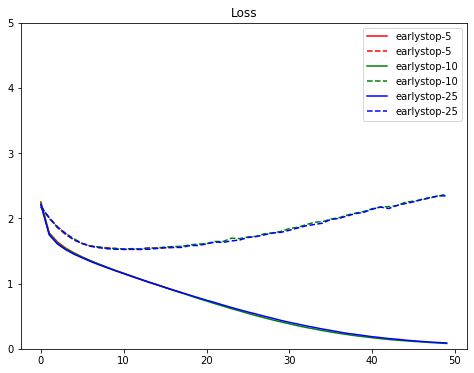

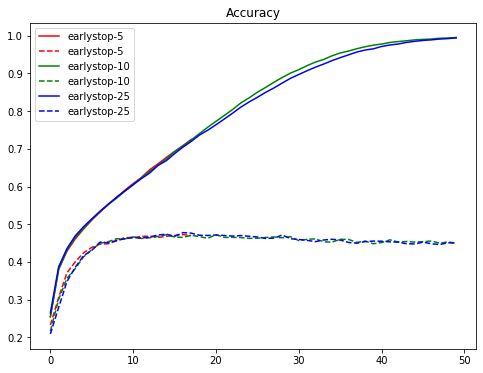

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
